In [3]:
import json
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/My Drive/QA/"

Mounted at /content/drive


In [4]:
# Load the data
f = open(project_dir+"train-v2.0.json",mode="r",encoding="utf-8")
raw_data = json.load(f)

In [5]:
pip install transformers -U

     |████████████████████████████████| 3.8 MB 7.4 MB/s 
     |████████████████████████████████| 895 kB 33.5 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 
     |████████████████████████████████| 6.5 MB 46.4 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
# Pre-process the data
import nltk
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
nltk.download("punkt")

def pre_process(raw_data,max_input_samples,max_context_length,max_question_length,max_answer_length):
  """keys = {
        "version":
        "data":[{
          "title":
          "paragraphs":[{
                  "qas":[{"question":
              "answers":
              }]
            "context":
          }]

        }]
             }  """
  "Fill here"
  data = []
  data_tokenized = []
  data1 = raw_data["data"]
  count = 0
  contexts = []
  questions = []
  answers = []
  for data_ele in data1:
    for para in data_ele["paragraphs"]:
      qas = para["qas"]
      context = [k.lower() for k in nltk.word_tokenize(para["context"])]
      #context_tokenized = tokenizer(para["context"], padding = True)
      if len(context) <= max_context_length:
        for qa in qas:
          que = [k.lower() for k in nltk.word_tokenize(qa["question"])]
          #que_tokenized = tokenizer(qa["question"], padding = True)
          if len(qa["answers"]) == 1:
            ans = [k.lower() for k in nltk.word_tokenize(qa["answers"][0]["text"])]
            ans_start = qa["answers"][0]["answer_start"]
            answer_indices = [ans_start, ans_start+len(ans)]
            if "how" not in que and "why" not in que:
              if len(que) <= max_question_length and len(que) <= max_answer_length:
                if count <= max_input_samples:
                  data.append([context,que,ans])
                  contexts.append(para["context"])
                  questions.append(qa["question"])
                  #data_tokenized.append([context_tokenized,que_tokenized,answer_indices])
                  count = count + 1
                else:
                  break
    if count >  max_input_samples:
      break
  return data, contexts, questions, answer_indices

max_input_samples = 1000
max_context_length = 300
max_question_length = 50
max_answer_length = 50

data, contexts, questions, answer_indices = pre_process(raw_data,max_input_samples,max_context_length,max_question_length,max_answer_length)
contexts_tokenized = tokenizer(contexts, padding = True, truncation= True, return_tensors = "pt")
questions_tokenized = tokenizer(questions, padding= True, truncation = True, return_tensors = "pt")

contexts_tokenized = contexts_tokenized["input_ids"]
questions_tokenized = questions_tokenized["input_ids"]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(array([  1., 316., 507., 151.,  22.,   4.,   0.,   0.,   0.,   0.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
 <a list of 10 Patch objects>)

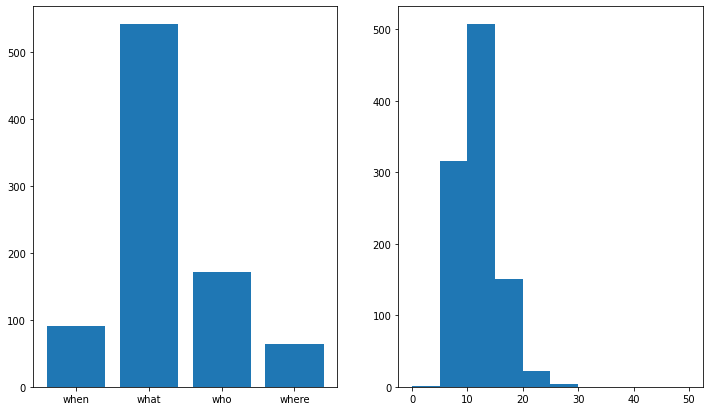

In [7]:
## data distribution
what_count = 0
who_count = 0
when_count = 0
where_count = 0
ques_length_list = []
for one_set in data:
  ques_length = 0 
  for ques_word in one_set[1]:
    ques_length = ques_length + 1
    if ques_word == 'when':
      when_count = when_count + 1
    elif ques_word == 'what':
      what_count = what_count + 1
    elif ques_word == 'who':
      who_count = who_count + 1
    elif ques_word == 'where':
      where_count = where_count + 1
  ques_length_list.append(ques_length)
#print(when_count)
#print(who_count)
#print(what_count)
#print(where_count)
#print(ques_length_list)

ques_data = {}
ques_data['when'] = when_count
ques_data['what'] = what_count
ques_data['who'] = who_count
ques_data['where'] = where_count
names = list(ques_data.keys())
values = list(ques_data.values())

from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].bar(names, values)
axs[1].hist(ques_length_list, bins = [i*5 for i in range(11)])


In [8]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import nltk

WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'


def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in WHITELIST:
            valid_word = True
            break
    if valid_word is False:
        return False
    return True

max_target_vocab_size = 5000
max_input_vocab_size = 5000

data_set = raw_data["data"]
input_data_samples = []
output_data_samples = []

input_max_seq_length = 0
target_max_seq_length = 0

input_counter = Counter()
target_counter = Counter()

input_data_samples = []
output_data_samples = []

data_set1 = []
count = 0
for sample in data_set:
  for para in sample["paragraphs"]:
      qas = para["qas"]
      context = [k.lower() for k in nltk.word_tokenize(para["context"])]
      if len(context) <= max_context_length:
        for qa in qas:
          que = [k.lower() for k in nltk.word_tokenize(qa["question"])]
          if len(qa["answers"]) == 1:
            if "how" not in que and "why" not in que:
              if len(que) <= max_question_length and len(que) <= max_answer_length:
                if count <= max_input_samples:
                  data_set1.append([para["context"],qa["question"],qa["answers"][0]["text"]])
                  count = count + 1
                else:
                  break
  if count > max_input_samples:
    break

for sample in data_set1:
    #print(sample)
    paragraph, question, answer = sample
    paragraph_word_list = [w.lower() for w in nltk.word_tokenize(paragraph) if in_white_list(w)]
    question_word_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
    answer_word_list = [w.lower() for w in nltk.word_tokenize(answer) if in_white_list(w)]

    input_data = paragraph_word_list + ['Q'] + question_word_list
    output_data = ['START'] + answer_word_list + ['END']

    input_data_samples.append(input_data)
    output_data_samples.append(output_data)

    for w in input_data:
        input_counter[w] += 1
    for w in output_data:
        target_counter[w] += 1

    input_max_seq_length = max(input_max_seq_length, len(input_data))
    target_max_seq_length = max(target_max_seq_length, len(output_data))

input_word2idx = dict()
target_word2idx = dict()
for idx, word in enumerate(input_counter.most_common(max_input_vocab_size)):
    input_word2idx[word[0]] = idx + 2
for idx, word in enumerate(target_counter.most_common(max_target_vocab_size)):
    target_word2idx[word[0]] = idx + 1

target_word2idx['UNK'] = 0
input_word2idx['PAD'] = 0
input_word2idx['UNK'] = 1

input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_input_tokens = len(input_idx2word)
num_target_tokens = len(target_idx2word)

input_encoded_data_samples = []
target_encoded_data_samples = []

for input_data, output_data in zip(input_data_samples, output_data_samples):
    input_encoded_data = []
    target_encoded_data = []
    for word in input_data:
        if word in input_word2idx:
            input_encoded_data.append(input_word2idx[word])
        else:
            input_encoded_data.append(1)
    for word in output_data:
        if word in target_word2idx:
            target_encoded_data.append(target_word2idx[word])
        else:
            target_encoded_data.append(0)
    input_encoded_data_samples.append(input_encoded_data)
    target_encoded_data_samples.append(target_encoded_data)

samples = [input_encoded_data_samples, target_encoded_data_samples]
print(samples[0][0])


[11, 772, 1377, 1378, 1379, 152, 110, 120, 2, 831, 32, 34, 121, 183, 2, 397, 2, 200, 524, 6, 280, 4, 152, 6, 439, 5, 260, 2, 440, 2, 23, 65, 5, 570, 203, 6, 863, 948, 24, 9, 46, 2, 6, 1380, 8, 471, 5, 3, 230, 646, 24, 234, 183, 7, 1381, 62, 10, 46, 4, 1293, 25, 13, 124, 2, 320, 250, 2, 3, 87, 80, 44, 7, 3, 92, 10, 441, 306, 582, 7, 70, 74, 4, 40, 408, 253, 3, 185, 7, 11, 10, 207, 33, 2, 261, 5, 50, 389, 2, 28, 390, 13, 24, 9, 75, 68, 204, 2, 177, 193, 125, 73, 6, 188, 3, 109, 211, 114, 264, 129, 254, 5, 50, 6, 798, 832, 4, 22, 54, 36, 58, 616, 326, 525, 21]


In [9]:
print(input_max_seq_length)

311


In [9]:
def generate_batch(input_data, target_data, batch_size):
    num_batches = len(input_data) // batch_size

    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * batch_size
            end = (batchIdx + 1) * batch_size
            encoder_input_data_batch = pad_sequences(input_data[start:end], input_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(batch_size, target_max_seq_length,
                                                        num_target_tokens))
            decoder_input_data_batch = np.zeros(shape=(batch_size, target_max_seq_length,
                                                       num_target_tokens))
            for lineIdx, target_wid_list in enumerate(target_data[start:end]):
                for idx, wid in enumerate(target_wid_list):
                    if wid == 0:  # UNKNOWN
                        continue
                    decoder_input_data_batch[lineIdx, idx, wid] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, wid] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

In [10]:
# Create a model

from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout, add, RepeatVector
from tensorflow.keras.optimizers import SGD

def create_model(num_input_tokens, input_max_seq_length, num_target_tokens):
        hidden_units = 256

        encoder_inputs = Input(shape=(None,), name='encoder_inputs')
        encoder_embedding = Embedding(input_dim=num_input_tokens, output_dim=hidden_units,
                                      input_length=input_max_seq_length, name='encoder_embedding')
        
        encoder_lstm = LSTM(units=hidden_units, return_state=True, name='encoder_lstm')
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, num_target_tokens), name='decoder_inputs')
        decoder_lstm = LSTM(units=hidden_units, return_state=True, return_sequences=True, name='decoder_lstm')
        decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
        decoder_dense = Dense(units=num_target_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = Dropout(0.3)(decoder_outputs)
        decoder_outputs = decoder_dense(decoder_outputs)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        #opt = SGD(lr=0.01)
        model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

        encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(hidden_units,)), Input(shape=(hidden_units,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

        return model, encoder_model, decoder_model

model, encoder_model, decoder_model = create_model(num_input_tokens, input_max_seq_length, num_target_tokens)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, None, 256)    905472      ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None, 924)]  0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 256),        525312      ['encoder_embedding[0][0]']      
                                 (None, 256),                                                 

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(samples[0], samples[1], test_size=0.2,random_state=40)

In [12]:
from keras.preprocessing.sequence import pad_sequences

batch_size = 64
train_gen = generate_batch(x_train, y_train, batch_size)
test_gen = generate_batch(x_test, y_test, batch_size)
a = next(train_gen)
a = next(train_gen)

b = a[0][0]
r = (len(b),len(b[0]))
print(r)
train_num_batches = len(x_train) // batch_size
test_num_batches = len(x_test) // batch_size



(64, 274)


In [14]:
weight_file_path = project_dir + "seq2seq200.h5"
checkpoint = ModelCheckpoint(filepath=weight_file_path, monitor='val_loss', mode='min', save_best_only=True,verbose=1)
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=25)

history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                    epochs=200,
                                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches,
                                    callbacks=[checkpoint,reduce_alpha])

model.save_weights(weight_file_path)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


12/12 [==============================] - ETA: 0s - loss: 0.9270 - accuracy: 0.0437
Epoch 1: val_loss improved from inf to 0.86197, saving model to /content/drive/My Drive/QA/seq2seq200.h5
12/12 [==============================] - 27s 2s/step - loss: 0.9270 - accuracy: 0.0437 - val_loss: 0.8620 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.8449 - accuracy: 0.0476
Epoch 2: val_loss did not improve from 0.86197
12/12 [==============================] - 31s 3s/step - loss: 0.8449 - accuracy: 0.0476 - val_loss: 0.8639 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.8421 - accuracy: 0.0476
Epoch 3: val_loss did not improve from 0.86197
12/12 [==============================] - 23s 2s/step - loss: 0.8421 - accuracy: 0.0476 - val_loss: 0.8655 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.0476
Epoch 4

In [15]:
# Test the model

def reply(paragraph, question):
        input_seq = []
        input_wids = []
        input_text = paragraph.lower() + ' Q ' + question.lower()
        for word in nltk.word_tokenize(input_text):
            if word != 'Q' and (not in_white_list(word)):
                continue
            idx = 1  # default [UNK]
            if word in input_word2idx:
                idx = input_word2idx[word]
            input_wids.append(idx)
        input_seq.append(input_wids)
        input_seq = pad_sequences(input_seq, input_max_seq_length)
        states_value = encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, num_target_tokens))
        target_seq[0, 0, target_word2idx['START']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'START' and sample_word != 'END':
                target_text += ' ' + sample_word

            if sample_word == 'END' or target_text_len >= target_max_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, num_target_tokens))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()


for i in range(20):
    index = i * 10
    paragraph, question, actual_answer = data_set1[index]
    predicted_answer = reply(paragraph, question)
    print('context: ', paragraph)
    print('question: ', question)
    print({'guessed_answer': predicted_answer, 'actual_answer': actual_answer})
    print("\n")

context:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
question:  When did Beyonce start becoming popular?
{'guessed_answer': 'songs', 'actual_answer': 'in the late 1990s'}


context:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in

In [ ]:
# precision, recall, f1-score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
precision = precision_score(true_values, predict_values)
recall = recall_score(true_values, predict_values)
f1score = f1_score(true_values, predict_values)